# UPDATE: Vanessa atalanta outbreaks

In [1]:
# libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib import cm, colors
from scipy.stats import median_abs_deviation

In [2]:
# seaborn style for plots
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# get hex color codes of Dark2 matplotlib colormap
cmap = cm.get_cmap('Dark2', 8)
hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

MAD_FACTOR = 2

In [3]:
# import (updated) data
count_daily = pd.read_csv('../../data/all_species_count_daily_upd.csv',
                          parse_dates=['date'])

count_by_trap = pd.read_csv('../../data/all_species_count_by_trap_upd.csv',
                            parse_dates=['date'])

# focus on years 1998 to 2020
count_daily = count_daily[(count_daily.year >= 1998) & (count_daily.year <= 2020)].reset_index(drop=True)

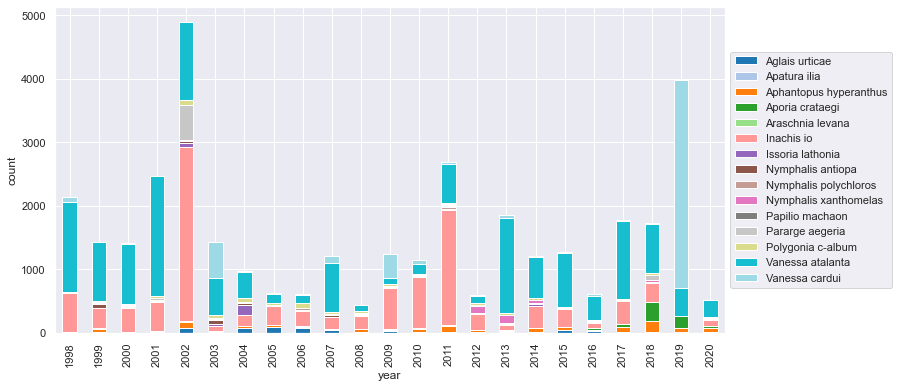

In [4]:
data = (count_daily
    .groupby(['species', 'year'], as_index=False)['count']
    .sum(min_count=1)
    .pivot(index='year', columns='species', values='count'))

fig, ax = plt.subplots(figsize=(12,6))
data.plot.bar(stacked=True, ax=ax, ylabel='count', colormap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Classify outbreaks

In order to classify outbreaks, we'll use the MAD threshold and visualise it in a stacked bar plot. Which season dominates in outbreak years?

In [5]:
def which_season(row):
    if row['month'] < 7:   # define spring as
        val = 'spring'     # april to june, skip
    elif row['month'] > 7: # july, and autumn from
        val = 'autumn'     # august to october
    else:
        val = 'july'
    return val

# add season as column and summarise data to total counts per year & season
count_daily['season'] = count_daily.apply(which_season, axis=1)
count_season = count_daily.groupby(['species', 'year', 'season'], as_index=False)['count'].sum(min_count=1)
count_season


,species,year,season,count
0,Aglais urticae,1998,autumn,2.0
1,Aglais urticae,1998,july,0.0
2,Aglais urticae,1998,spring,0.0
3,Aglais urticae,1999,autumn,1.0
4,Aglais urticae,1999,july,0.0
...,...,...,...,...
1030,Vanessa cardui,2019,july,336.0
1031,Vanessa cardui,2019,spring,2804.0
1032,Vanessa cardui,2020,autumn,1.0
1033,Vanessa cardui,2020,july,0.0


In [6]:
# compute MAD threshold (for all seasons & directions simultaneously)
mad = (count_daily
    .drop(columns=['tmp', 'day', 'month'])
    .groupby(['species', 'year'], as_index=False)
    .sum(min_count=1)
    .groupby('species', as_index=False)['count']
    .apply(median_abs_deviation, scale='normal'))
mad

,species,count
0,Aglais urticae,14.826022
1,Apatura ilia,0.000000
2,Aphantopus hyperanthus,26.686840
3,Aporia crataegi,2.965204
4,Araschnia levana,1.482602
5,Inachis io,198.668697
6,Issoria lathonia,7.413011
7,Nymphalis antiopa,10.378216
8,Nymphalis polychloros,10.378216
9,Nymphalis xanthomelas,2.965204


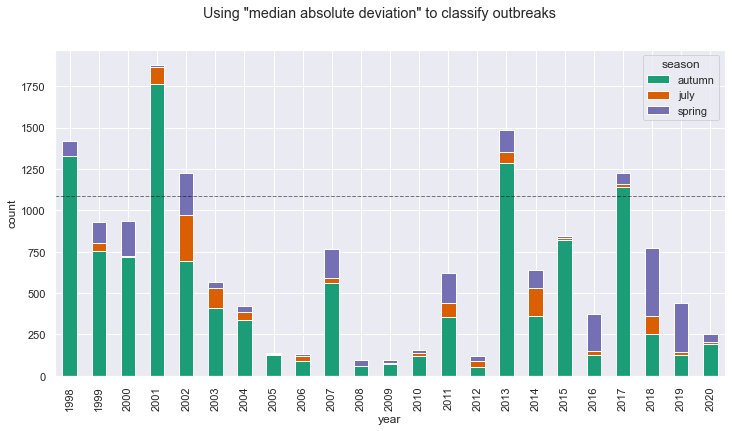

In [13]:
data = count_season[count_season.species == 'Vanessa atalanta'].pivot(index='year', columns='season', values='count')
mad_va = mad[mad.species == 'Vanessa atalanta']['count'].values

fig, ax = plt.subplots(figsize=(12,6))
data.plot.bar(stacked=True, ax=ax, ylabel='count')
ax.axhline(y=mad_va * MAD_FACTOR, ls='--', lw=1, c='k', alpha=0.5, label='mad')
fig.suptitle('Using "median absolute deviation" to classify outbreaks')
fig.savefig(f'../figs/kaliningrad/vatalanta/outbreaks_mad-criterion.png',
            dpi=600, bbox_inches='tight')

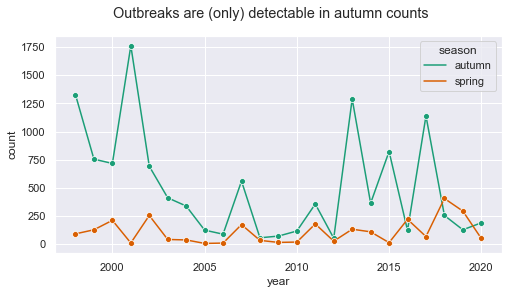

In [18]:
data = count_season[(count_season.species == 'Vanessa atalanta') & (count_season.season != 'july')]
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='year', y='count', hue='season', marker='o', data=data, ax=ax)
fig.suptitle('Outbreaks are (only) detectable in autumn counts')
fig.savefig(f'../figs/kaliningrad/vatalanta/outbreaks_per-season_joined.png',
            dpi=600, bbox_inches='tight')